In [30]:
import sys
sys.path.append('../../../')
import torch
from matplotlib import pyplot as plt
from tifffile import imread, imwrite
from sklearn.cluster import KMeans
import numpy as np
from glob import glob
from tqdm import tqdm

In [31]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [32]:
path="/group/jug/Sheida/pancreatic beta cells/download/high_c1/"
patch_size = 64
model = torch.load("/group/jug/Sheida/HDN models/19022024/background added to negative pair/model/Contrastive_MAE_best_vae.net")
model.mode_pred=True
model.eval()
model.to(device)

LadderVAE(
  (first_bottom_up): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): BottomUpDeterministicResBlock(
      (res): ResidualBlock(
        (block): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ELU(alpha=1.0)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): Dropout2d(p=0.2, inplace=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ELU(alpha=1.0)
          (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): Dropout2d(p=0.2, inplace=False)
        )
      )
    )
  )
  (top_down_layers): ModuleList(
    (0-3): 4 x TopDownLayer(
      (deterministic_block): Sequential(
        (0): TopDownDeterministicResBlock(
          (pre_conv): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), 

In [51]:
def clustering(mu):
    slice_features_mu = mu.astype(float)
    feature_flatten_mu = slice_features_mu.reshape(160, -1).T
    K_CENTRE = 8
    kmeans_mu = KMeans(
        n_clusters=K_CENTRE, init='k-means++', n_init=10,
        max_iter=1000, random_state=777
    )
    kmeans_mu.fit(feature_flatten_mu)
    labels_mu = kmeans_mu.predict(feature_flatten_mu)
    return labels_mu

In [34]:
def get_normalized_tensor(img,model,device):
    '''
    Normalizes tensor with mean and std.
    Parameters
    ----------
    img: array
        Image.
    model: Hierarchical DivNoising model
    device: GPU device.
    '''
    test_images = torch.from_numpy(img.copy()).to(device)
    data_mean = model.data_mean
    data_std = model.data_std
    test_images = (test_images-data_mean)/data_std
    return test_images

In [35]:
# for 4x4
def make_tiled(img):
    out = np.zeros([img.shape[0]+61, img.shape[1]+60])
    # make mirror margin of 2d image
    for i in range(30):
        out[i,30:30+img.shape[1]] = img[30-i-1,:]
        out[30:30+img.shape[0],30:30+img.shape[1]] = img
        out[30+img.shape[0]+i,30:30+img.shape[1]] = img[img.shape[0]-i-1,:]
    out[img.shape[0]+60,30:30+img.shape[1]] = img[img.shape[0]-31,:]
    for i in range(30):
        out[:,i] = out[:,60-i-1]
        out[:, 30+img.shape[1]+i] = out[:, 30+img.shape[1]-i-1]
    return out
    

In [23]:
# for 2x2
def make_tiled_x(img):
    out = np.zeros([img.shape[0]+63, img.shape[1]+62])
    # make mirror margin of 2d image
    for i in range(31):
        out[i,31:31+img.shape[1]] = img[31-i-1,:]
        out[31:31+img.shape[0],31:31+img.shape[1]] = img
        out[31+img.shape[0]+i,31:31+img.shape[1]] = img[img.shape[0]-i-1,:]
    out[img.shape[0]+62,31:31+img.shape[1]] = img[img.shape[0]-32,:]
    for i in range(31):
        out[:,i] = out[:,62-i-1]
        out[:, 31+img.shape[1]+i] = out[:, 31+img.shape[1]-i-1]
    return out

In [52]:
# img = imread(path+"data/test/high_c1_source_31.tif")
img = imread("/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif")
tiled = make_tiled(img)
img_height,img_width = 700,760
img = get_normalized_tensor(tiled,model,device)
output = np.zeros((160, 700, 760))
for i in tqdm(range(0, img_height, 4)):
    for j in range(0, img_width, 4):
# for i in tqdm(range(0, img_height, 2)):
#     for j in range(0, img_width, 2):
        img_t = img[i:i+64,j:j+64]
        # if img_t.shape != (64,64):
        #     print(img_t.shape)
        image_sample = img_t.view(1,1,64,64)
        image_sample = image_sample.to(device=device, dtype=torch.float)
        with torch.no_grad():
            sample = model(image_sample, y=image_sample)
            mus = sample['mu']
            output[:32,i:i+4,j:j+4] = sample['mu'][0][0].cpu().numpy()[:,14:18,14:18]
            output[32:64,i:i+4,j:j+4] = sample['mu'][1][0].cpu().numpy()[:,6:10,6:10]
            output[64:96,i:i+4,j:j+4] = sample['mu'][2][0].cpu().numpy()[:,2:6,2:6]
            output[96:128,i:i+4,j:j+4] = sample['mu'][3][0].cpu().numpy()
            output[128:160,i:i+4,j:j+4] = sample['mu'][4][0].cpu().numpy().repeat(2,axis=1).repeat(2,axis=2)
            # output[:32,i:i+2,j:j+2] = sample['mu'][0][0].cpu().numpy()[:,15:17,15:17]
            # output[32:64,i:i+2,j:j+2] = sample['mu'][1][0].cpu().numpy()[:,7:9,7:9]
            # output[64:96,i:i+2,j:j+2] = sample['mu'][2][0].cpu().numpy()[:,3:5,3:5]
            # output[96:128,i:i+2,j:j+2] = sample['mu'][3][0].cpu().numpy()[:,1:3,1:3]
            # output[128:160,i:i+2,j:j+2] = sample['mu'][4][0].cpu().numpy()


  2%|▏         | 4/175 [00:31<22:17,  7.82s/it]


KeyboardInterrupt: 

In [38]:
np.save("/group/jug/Sheida/HDN models/19022024/background added to negative pair/imgs/output_187.npy", output)

In [53]:
output = np.load("/group/jug/Sheida/HDN models/19022024/background added to negative pair/imgs/output_187.npy")

In [54]:
clusters = clustering(output)

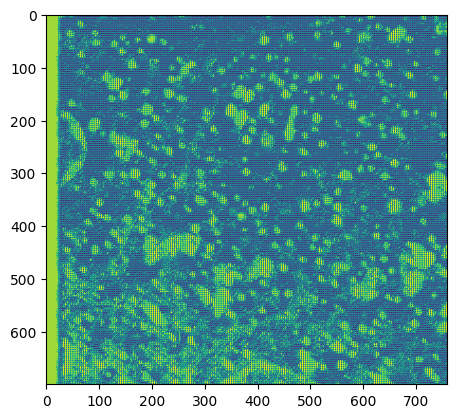

In [55]:
imwrite("/group/jug/Sheida/HDN models/19022024/background added to negative pair/imgs/187_8cluster.tif", clusters.reshape(700, 760))
plt.imshow(clusters.reshape(700, 760))
plt.show()

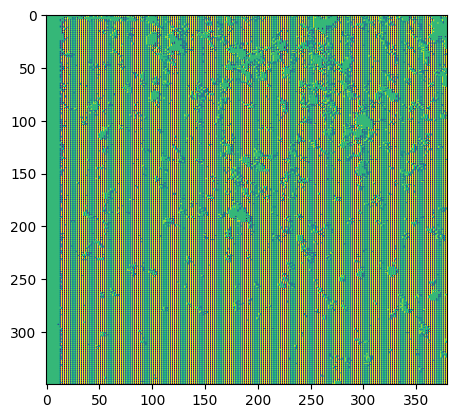

In [41]:
imwrite("/group/jug/Sheida/HDN models/19022024/background added to negative pair/imgs/187_4cluster_downscale.tif", clusters.reshape(700, 760)[::2,::2])
plt.imshow(clusters.reshape(700, 760)[::2,::2])
plt.show()

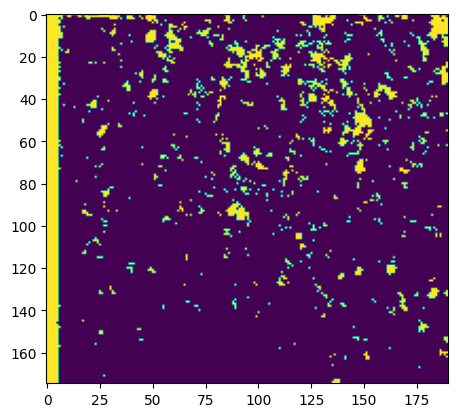

In [50]:
# imwrite("/group/jug/Sheida/HDN models/19022024/background added to negative pair/imgs/187_4cluster_downscale^2.tif", clusters.reshape(700, 760)[::4,::4])
plt.imshow(clusters.reshape(700, 760)[2::4,2::4])
plt.show()

In [46]:
def clustering_down_scale(index, mu):
    slice_features_mu = mu.astype(float)
    feature_flatten_mu = slice_features_mu.reshape(32, -1).T
    K_CENTRE = 4
    kmeans_mu = KMeans(
        n_clusters=K_CENTRE, init='k-means++', n_init=10,
        max_iter=1000, random_state=777
    )
    kmeans_mu.fit(feature_flatten_mu)
    labels_mu = kmeans_mu.predict(feature_flatten_mu)
    return labels_mu

(160, 768, 704)
(32, 352, 384)
/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif


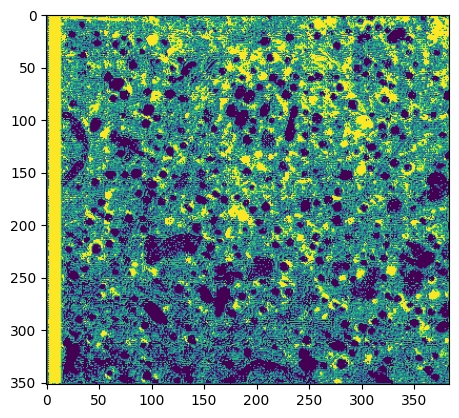

(32, 176, 192)
/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif


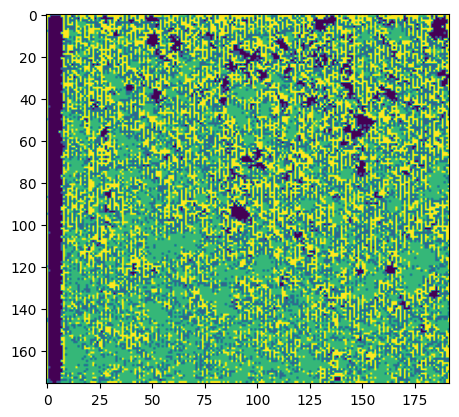

(32, 88, 96)
/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif


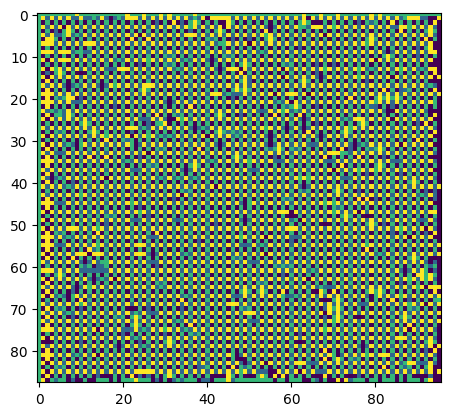

(32, 44, 48)
/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif


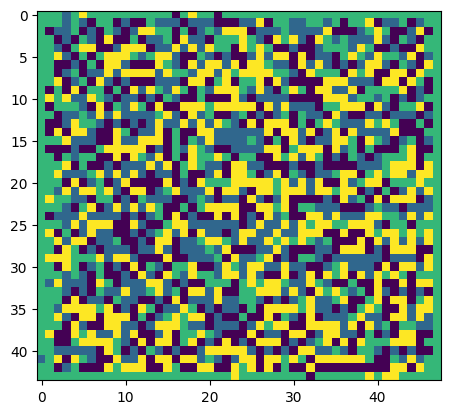

(32, 22, 24)
/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif


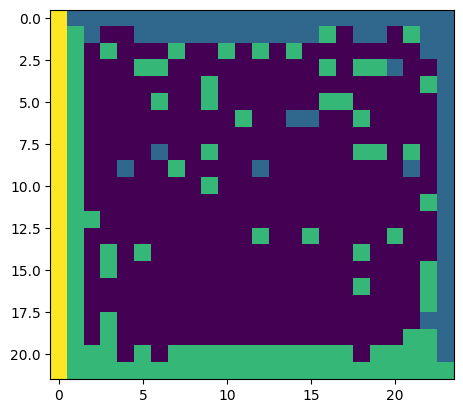

In [47]:
files = glob("/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif")
img_height,img_width = 699, 760
for i in files:
    img = imread(i)
    img_t = get_normalized_tensor(img,model,device)
    image_sample = img_t.view(1,1,img_height,img_width)
    image_sample = image_sample.to(device=device, dtype=torch.float)
    with torch.no_grad():
        sample = model(image_sample, image_sample)
        mus = sample['mu']
        output = np.zeros((160, 768, 704))

        print(output.shape)

        for idx in range(len(sample['mu'])):
            mu = sample['mu'][idx][0].cpu().numpy()
            print(mu.shape)
            output = clustering_down_scale(idx, mu)
            print(i)
            imwrite("/group/jug/Sheida/HDN models/19022024/background added to negative pair/imgs/187_"+str(idx)+".tif", output.reshape(22*(2**(4-idx)), 24*(2**(4-idx))))
            plt.imshow(output.reshape(22*(2**(4-idx)), 24*(2**(4-idx))))
            plt.show()

In [9]:
import torch.nn.functional as F
import torch
from torch.distributions import kl_divergence
from torch.distributions.normal import Normal

input = Normal(torch.tensor([0 for i in range(5)]), torch.tensor([1 for i in range(5)]))
target = Normal(torch.tensor([0.5 for i in range(5)]), torch.tensor([1 for i in range(5)]))
output = kl_divergence(input, target)
print("input: ",input,"\ntarget: ",target,"\noutput: ",output)
print(torch.sum(output))

input:  Normal(loc: torch.Size([5]), scale: torch.Size([5])) 
target:  Normal(loc: torch.Size([5]), scale: torch.Size([5])) 
output:  tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250])
tensor(0.6250)
